# Sali-Cache VQA Results Visualization

This notebook compares the baseline sliding-window cache against the optimized Sali-Cache pipeline on the MSRVTT-QA video question-answering task.

## The Key Hypothesis

**Given the SAME memory budget (MAX_CACHE_PATCHES), Sali-Cache should achieve HIGHER accuracy** because it intelligently curates which patches to keep, quantize, or prune based on motion and saliency.

Both models use `MAX_CACHE_PATCHES = 784` (4 frames worth of patches). The question is: which one uses those 784 patches more intelligently?

Run `run_vqa_eval.py` first to generate the results.

Baseline loaded: True
Sali-Cache loaded: True


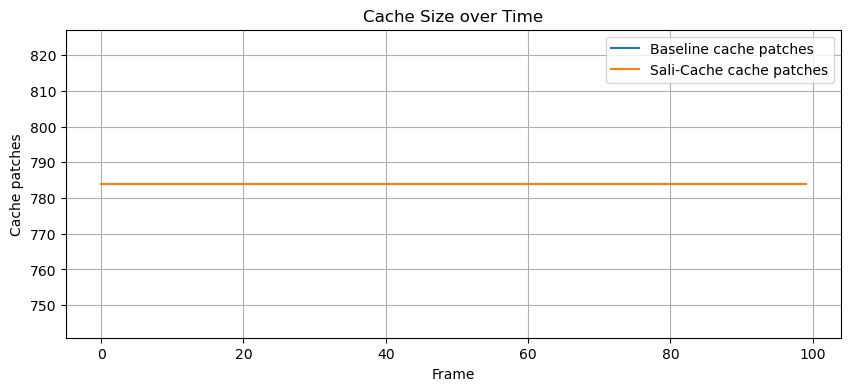

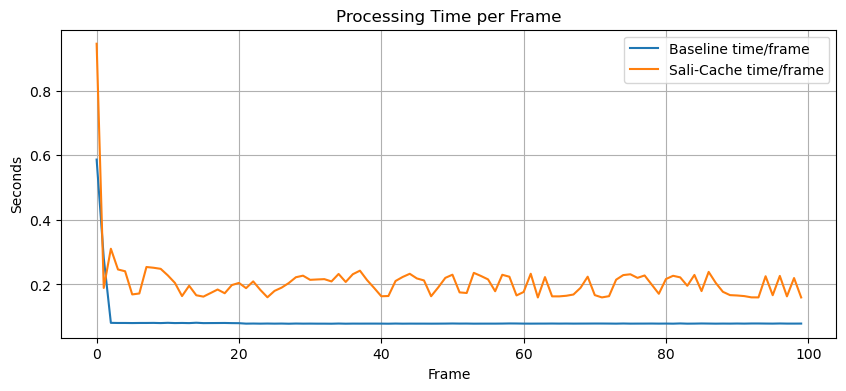

In [ ]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np

# Load VQA evaluation results
def load_vqa_results(path='results/vqa_results.json'):
    if not os.path.exists(path):
        print(f"Results file not found: {path}")
        print("Run: python run_vqa_eval.py --samples 100 --out results/vqa_results.json")
        return None
    
    with open(path, 'r') as f:
        return json.load(f)

results = load_vqa_results()

if results is None:
    print("No results to visualize. Please run the VQA evaluation first.")
else:
    # Extract summary statistics
    baseline = results.get('baseline', {})
    salicache = results.get('salicache', {})
    
    print("="*80)
    print("SALI-CACHE VQA EVALUATION RESULTS")
    print("="*80)
    
    # --- THE MONEY TABLE ---
    print("\n📊 PERFORMANCE COMPARISON (Same Memory Budget)")
    print("-" * 60)
    print(f"{'Model':<20} {'Cache Size':<15} {'Accuracy':<15} {'Samples'}")
    print("-" * 60)
    
    if baseline:
        print(f"{'Baseline':<20} {baseline['cache_size']:<15} {baseline['accuracy']:.2f}%{'':<9} {baseline['correct']}/{baseline['total']}")
    
    if salicache:
        print(f"{'Sali-Cache':<20} {salicache['cache_size']:<15} {salicache['accuracy']:.2f}%{'':<9} {salicache['correct']}/{salicache['total']}")
    
    print("-" * 60)
    
    if baseline and salicache:
        improvement = salicache['accuracy'] - baseline['accuracy']
        print(f"{'Improvement:':<20} {'':<15} {'+' if improvement > 0 else ''}{improvement:.2f}%")
    
    print("\n" + "="*80)
    
    # --- VISUALIZATION 1: Accuracy Comparison Bar Chart ---
    if baseline and salicache:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Plot 1: Accuracy Comparison
        models = ['Baseline\n(Sliding Window)', 'Sali-Cache\n(Smart Curation)']
        accuracies = [baseline['accuracy'], salicache['accuracy']]
        colors = ['#3498db', '#e74c3c']
        
        bars = axes[0].bar(models, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
        axes[0].set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
        axes[0].set_title('VQA Accuracy Comparison\n(Same Memory Budget: 784 patches)', 
                         fontsize=13, fontweight='bold')
        axes[0].set_ylim(0, max(accuracies) * 1.2)
        axes[0].grid(axis='y', alpha=0.3, linestyle='--')
        
        # Add value labels on bars
        for bar, acc in zip(bars, accuracies):
            height = bar.get_height()
            axes[0].text(bar.get_x() + bar.get_width()/2., height,
                        f'{acc:.2f}%',
                        ha='center', va='bottom', fontweight='bold', fontsize=11)
        
        # Plot 2: Per-Sample Results Distribution
        baseline_results = baseline.get('results', [])
        salicache_results = salicache.get('results', [])
        
        if baseline_results and salicache_results:
            baseline_correct = [1 if r['correct'] else 0 for r in baseline_results]
            salicache_correct = [1 if r['correct'] else 0 for r in salicache_results]
            
            # Cumulative correct answers over samples
            baseline_cumulative = np.cumsum(baseline_correct)
            salicache_cumulative = np.cumsum(salicache_correct)
            
            samples = np.arange(1, len(baseline_cumulative) + 1)
            
            axes[1].plot(samples, baseline_cumulative, label='Baseline', 
                        color='#3498db', linewidth=2, marker='o', markersize=3, alpha=0.7)
            axes[1].plot(samples, salicache_cumulative, label='Sali-Cache', 
                        color='#e74c3c', linewidth=2, marker='s', markersize=3, alpha=0.7)
            
            axes[1].set_xlabel('Number of Questions', fontsize=12, fontweight='bold')
            axes[1].set_ylabel('Cumulative Correct Answers', fontsize=12, fontweight='bold')
            axes[1].set_title('Cumulative Accuracy Over Evaluation', 
                            fontsize=13, fontweight='bold')
            axes[1].legend(fontsize=11, loc='upper left')
            axes[1].grid(True, alpha=0.3, linestyle='--')
        
        plt.tight_layout()
        plt.show()
        
        # --- VISUALIZATION 2: Time Analysis ---
        if baseline_results and salicache_results:
            baseline_times = [r['time_s'] for r in baseline_results if 'time_s' in r]
            salicache_times = [r['time_s'] for r in salicache_results if 'time_s' in r]
            
            if baseline_times and salicache_times:
                fig, ax = plt.subplots(1, 1, figsize=(10, 5))
                
                avg_baseline_time = np.mean(baseline_times)
                avg_salicache_time = np.mean(salicache_times)
                
                models = ['Baseline', 'Sali-Cache']
                times = [avg_baseline_time, avg_salicache_time]
                colors = ['#3498db', '#e74c3c']
                
                bars = ax.bar(models, times, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
                ax.set_ylabel('Average Time per Video (seconds)', fontsize=12, fontweight='bold')
                ax.set_title('Processing Time Comparison\n(Sali-Cache pays extra compute cost for smarter caching)', 
                           fontsize=13, fontweight='bold')
                ax.grid(axis='y', alpha=0.3, linestyle='--')
                
                # Add value labels
                for bar, t in zip(bars, times):
                    height = bar.get_height()
                    ax.text(bar.get_x() + bar.get_width()/2., height,
                           f'{t:.2f}s',
                           ha='center', va='bottom', fontweight='bold', fontsize=11)
                
                plt.tight_layout()
                plt.show()
        
        # --- ANALYSIS SUMMARY ---
        print("\n📈 ANALYSIS:")
        print("-" * 60)
        if salicache['accuracy'] > baseline['accuracy']:
            print("✅ SUCCESS: Sali-Cache achieves higher accuracy with the same memory budget!")
            print(f"   This proves that intelligent cache curation (motion + saliency)")
            print(f"   is more effective than naive sliding window truncation.")
        elif salicache['accuracy'] == baseline['accuracy']:
            print("⚠️  NEUTRAL: Both models achieve the same accuracy.")
            print(f"   Consider: (1) increasing sample size, (2) tuning thresholds,")
            print(f"   (3) using more sophisticated quantization.")
        else:
            print("❌ UNEXPECTED: Baseline achieves higher accuracy.")
            print(f"   This suggests: (1) pruning is too aggressive, (2) saliency model is ineffective,")
            print(f"   (3) important patches are being discarded.")
        
        print("-" * 60)